In [1]:
library(splatter)

library(scater)
library(Seurat)
library(dplyr)
library(Matrix)
# library(clues)
# library(SC3)
library(SingleCellExperiment)
library(harmony)
library(FNN)
library(flexclust)
library(stats)
dirs="/data02/tguo/space_batch_effect/simulate/"

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

NULL

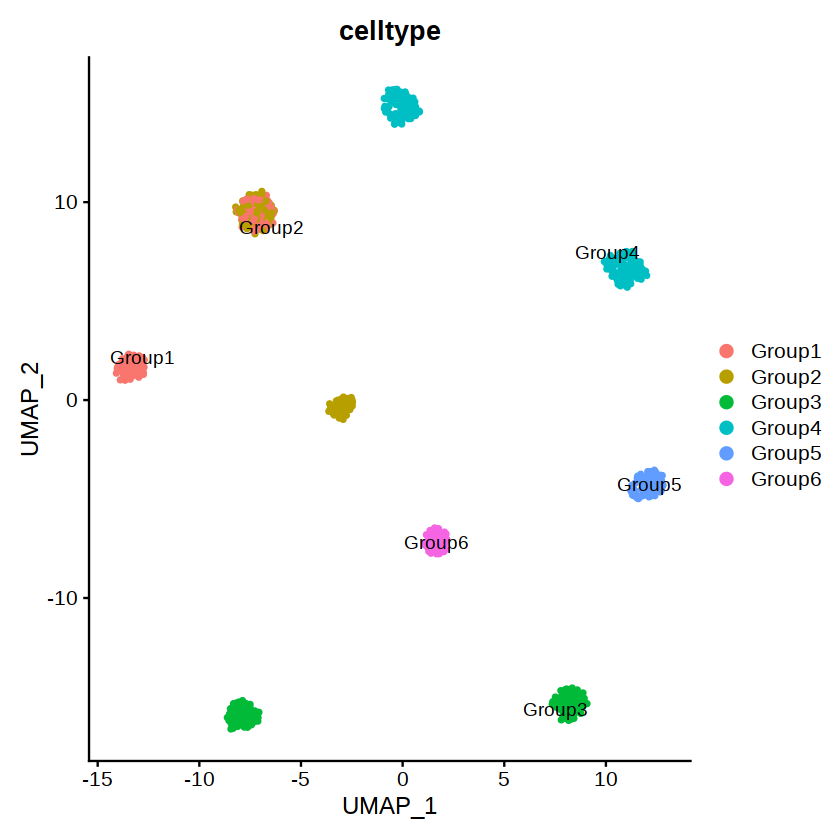

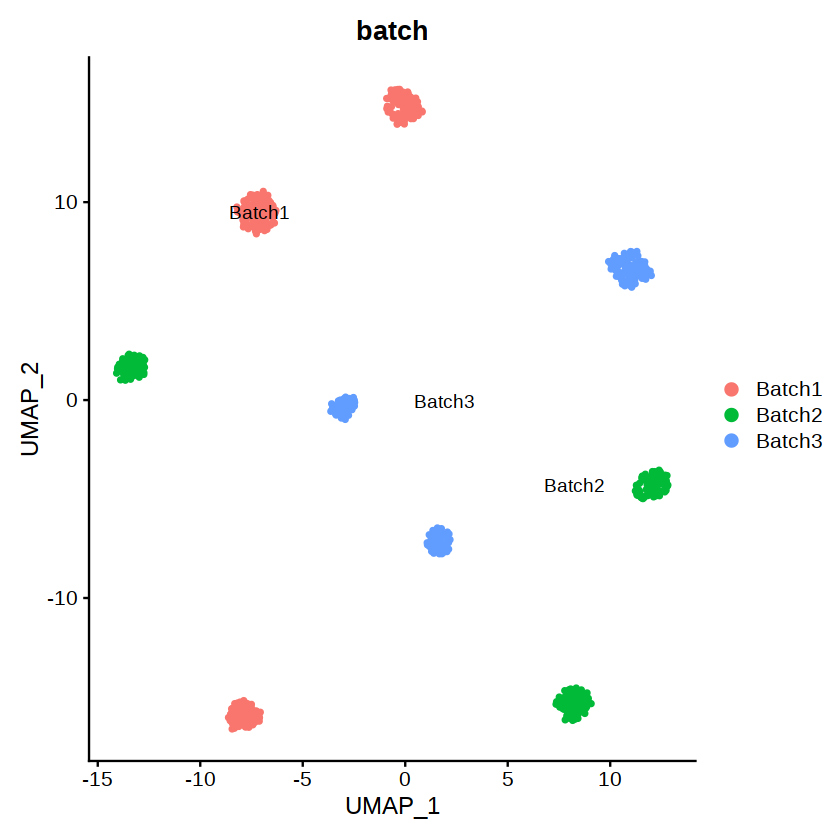

In [7]:
batch_sim1=1
batch_sim2=2
batch_sim=paste("_",batch_sim1,"_",batch_sim2,sep="")
types='_3batch_types6'
N_gene=500
N_cell=c(500,500,500)
seed=1234
#作为base, 每个gene的分布
base_mean_rate=15
base_mean_shape=0.1
#每个cell的library size
cell_reads_num=10
cell_reads_var=0.1
##batch 
batch_loc=c(0,batch_sim1,batch_sim2)
batch_scale=c(1,1,1)
#每个细胞类型的细胞数量所占的比例
cell_type_prob=c(0.15,0.15,0.2,0.2,0.15,0.15)
# cell_type_prob=c(0.06,0.16,0.28,0.28,0.16,0.06)
#每个细胞类型相对于base发生差异表达的基因的比例，用来衡量两个type的差异
gene_diff_prob=c(0.01,0.01,0.7,0.8,0.6,0.9)
gene_down_prob=c(0.1,0.1,0.1,0.1,0.1,0.1)
gene_diff_loc=c(1,1,10,15,15,25)
gene_diff_scale=c(1,1,1,1,1,1)
#发生drop out的概率
drop_mid=0
drop_shape=-5
#极端高表达的gene所占的比例
outlier=0.0001
params <- newSplatParams()
params<- setParams(params,update=list(nGenes = N_gene, mean.rate = base_mean_rate, mean.shape=base_mean_shape,out.prob=outlier,
                                      batchCells = N_cell,lib.loc=cell_reads_num, lib.scale=cell_reads_var, lib.norm=FALSE, 
                                      batch.facLoc=batch_loc,batch.facScale=batch_scale,group.prob=cell_type_prob,
                                      de.prob=gene_diff_prob, de.facLoc=gene_diff_loc,de.facScale=gene_diff_scale, 
                                      dropout.type="experiment", dropout.mid=drop_mid, dropout.shape=drop_shape,seed=seed))
sim<-splatSimulate(params, verbose = FALSE, method="groups")
sim<-logNormCounts(sim)
mat=sim@assays@data$logcounts
group<-sim$Group
batch<-sim$Batch
meta=data.frame(celltype=group,batch=batch)
rownames(meta)<-colnames(mat)

cc1=c('Group1','Group3','Group4','Group2')
cc2=c('Group5','Group1','Group3')
cc3=c('Group4','Group2','Group6')
id1=intersect(which(meta$celltype%in%cc1),which(meta$batch=='Batch1'))
id2=intersect(which(meta$celltype%in%cc2),which(meta$batch=='Batch2'))
id3=intersect(which(meta$celltype%in%cc3),which(meta$batch=='Batch3'))
mat=mat[,c(id1,id2,id3)]
meta=meta[c(id1,id2,id3),]



writeMM(mat,paste(dirs,"origin/mat",batch_sim,types,".mtx",sep=""))
write.table(rownames(mat),paste(dirs,"origin/mat_rownames",batch_sim,types,".txt",sep=""),col.names=F,row.names=F,quote=F)
write.table(colnames(mat),paste(dirs,"origin/mat_colnames",batch_sim,types,".txt",sep=""),col.names=F,row.names=F,quote=F)
write.table(meta,paste(dirs,"origin/meta",batch_sim,types,".txt",sep=""),col.names=T,row.names=T,sep=',',quote=F)


#########################
obj2<-CreateSeuratObject(counts=mat,meta.data=meta)
VariableFeatures(obj2)<-rownames(mat)
obj2@assays$RNA@scale.data=as.matrix(mat)
obj2<-RunPCA(obj2,npcs=30,verbose=F)
obj2<-RunUMAP(obj2,reduction='pca',dims=1:30,verbose=F)
# obj2<-FindNeighbors(obj2,dims=1:30)
# obj2<-FindClusters(obj2,resolution=0.4)
DimPlot(obj2,group.by='celltype',label=T)
DimPlot(obj2,group.by='batch',label=T)

# ub=unique(meta$batch)
# id=(meta$batch==ub[1])
# obj1<-CreateSeuratObject(counts=mat[,id],meta.data=meta[id,])
# VariableFeatures(obj1)<-rownames(mat[,id])
# obj1@assays$RNA@scale.data=as.matrix(mat[,id])
# obj1<-RunPCA(obj1,npcs=30,verbose=F)
# obj1<-RunUMAP(obj1,reduction='pca',dims=1:30,verbose=F)
# id=(meta$batch==ub[2])
# obj2<-CreateSeuratObject(counts=mat[,id],meta.data=meta[id,])
# VariableFeatures(obj2)<-rownames(mat[,id])
# obj2@assays$RNA@scale.data=as.matrix(mat[,id])
# obj2<-RunPCA(obj2,npcs=30,verbose=F)
# obj2<-RunUMAP(obj2,reduction='pca',dims=1:30,verbose=F)
# DimPlot(obj1,group.by='celltype',label=T)
# DimPlot(obj1,group.by='batch',label=T)
# DimPlot(obj2,group.by='celltype',label=T)
# DimPlot(obj2,group.by='batch',label=T)



# ########GTT#########
# embed=read.csv(paste(dirs,"gtt_output/gac_da_embed_correct",batch_sim,types,".txt",sep=""),header=T,row.names=1)
# mat=readMM(paste(dirs,"origin/mat",batch_sim,"_types2.mtx",sep=""))
# colnames(mat)=read.table(paste(dirs,"origin/mat_colnames",batch_sim,types,".txt",sep=""))[,1]
# rownames(mat)=read.table(paste(dirs,"origin/mat_rownames",batch_sim,types,".txt",sep=""))[,1]
# meta=read.table(paste(dirs,"origin/meta",batch_sim,types,".txt",sep=""),header=T,row.names=1,stringsAsFactors=F,sep=',')
# mat=as(mat,'dgCMatrix')
# obj<-CreateSeuratObject(counts=mat,meta.data=meta)
# obj[['GTT']]<-CreateDimReducObject(embeddings=as.matrix(embed), key = "GTT_", assay = DefaultAssay(obj))

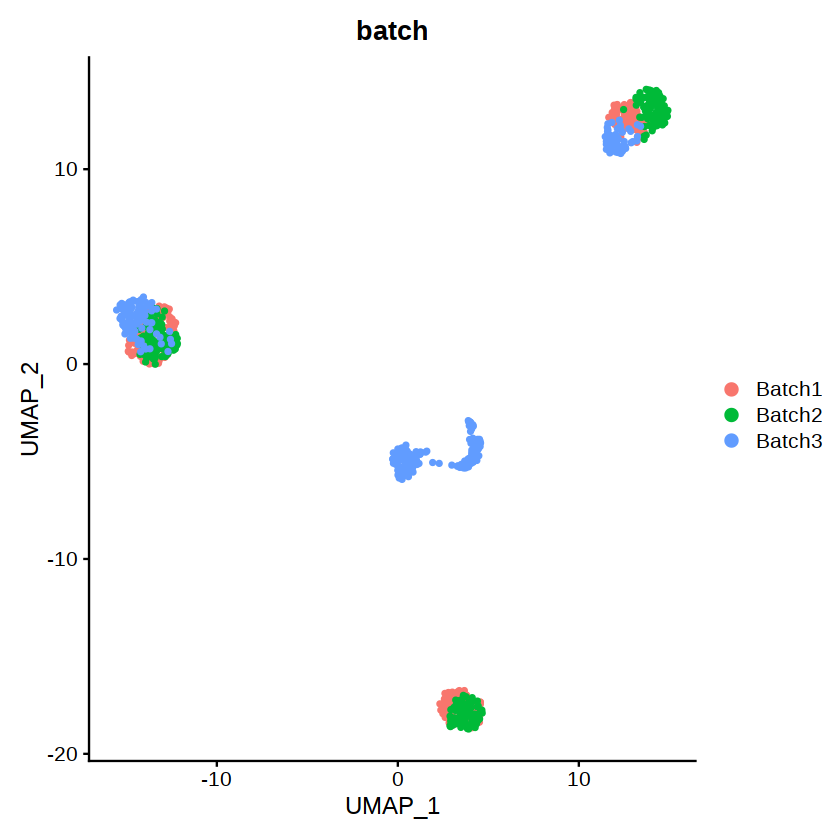

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 200 features requested have zero variance (running reduction without them): Gene9, Gene11, Gene13, Gene15, Gene20, Gene21, Gene23, Gene27, Gene28, Gene29, Gene36, Gene39, Gene40, Gene41, Gene48, Gene52, Gene54, Gene55, Gene56, Gene57, Gene58, Gene60, Gene62, Gene63, Gene67, Gene68, Gene69, Gene70, Gene73, Gene74, Gene75, Gene76, Gene77, Gene83, Gene87, Gene89, Gene90, Gene92, Gene95, Gene97, Gene101, Gene103, Gene107, Gene111, Gene113, Gene117, Gene120, Gene122, Gene125, Gene128, Gene138, Gene139, Gene140, Gene141, Gene142, Gene145, Gene147, Gene149, Gene154, Gene155, Gene163, Gene165, Gene171, Gene173, Gene174, Gene177, Gene179, Gene180, Gene184, Gene185, Gene186, Gene187, Gene189, Gene194, Gene195, Gene197, Gene199, Gene201, Gene204, Gene206, Gene208, Gene210, Gene214, Gene215, Gene216, Gene220, Gene226, Gene231, Gene233, Gene235, Gene236, Gene242, Gene245, Gene247, Gene248, Gene249, Ge

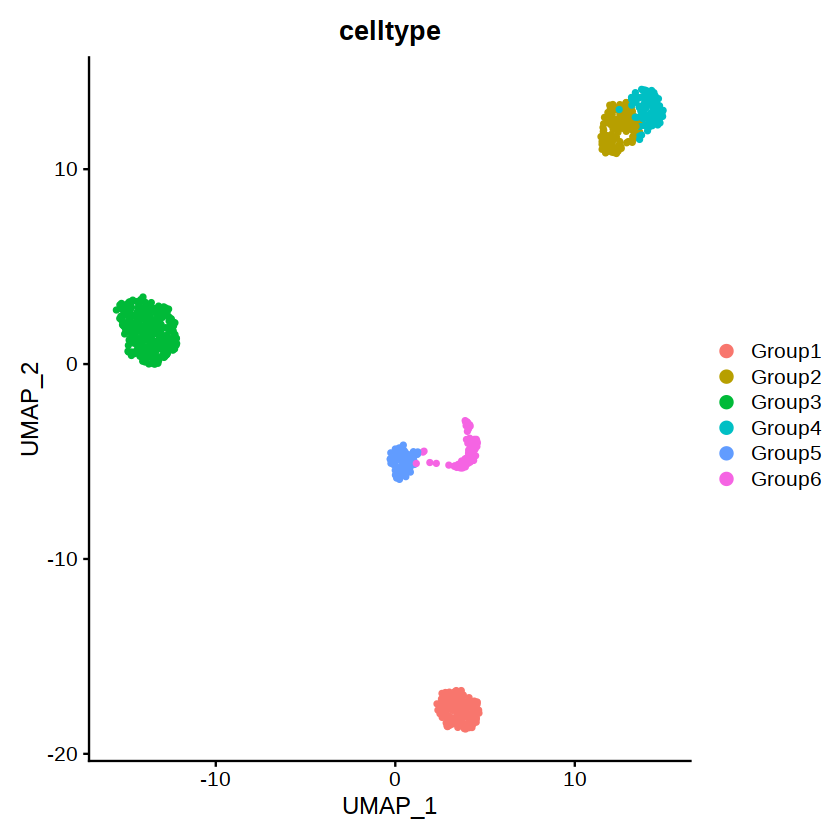

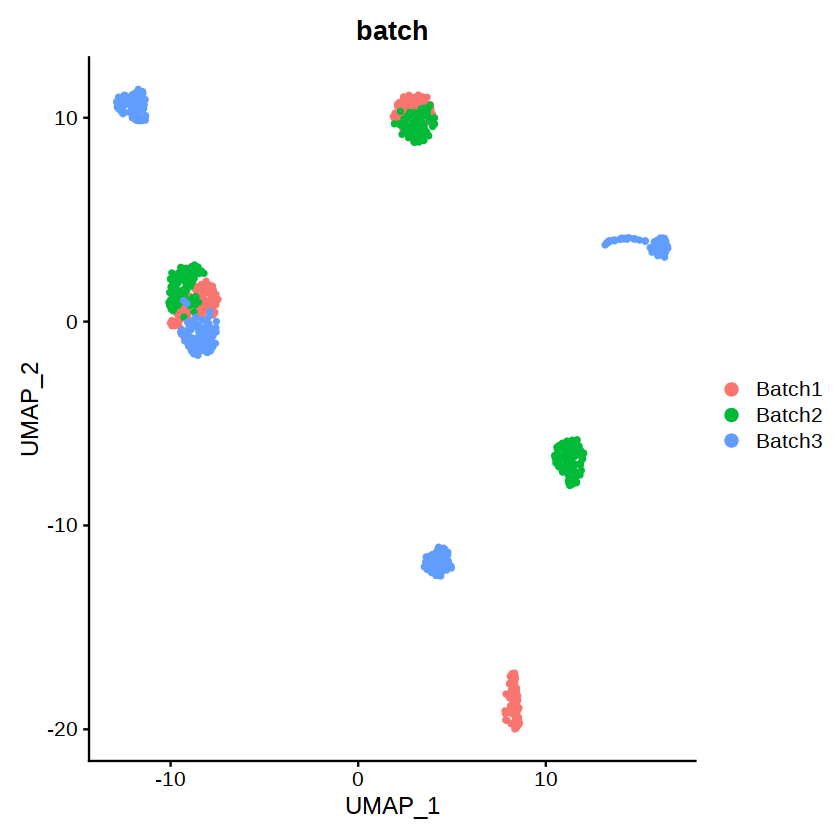

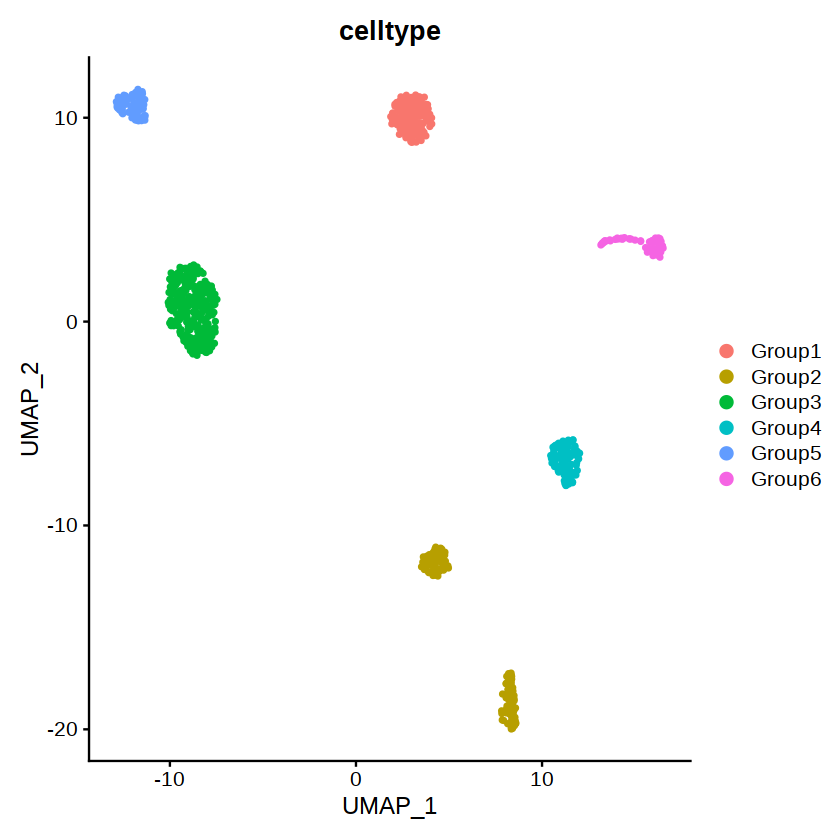

In [3]:
########################Seurat#############################
batch_sim="_1_2"
types="_3batch_types5"
mat=readMM(paste(dirs,"origin/mat",batch_sim,types,".mtx",sep=""))
colnames(mat)=read.table(paste(dirs,"origin/mat_colnames",batch_sim,types,".txt",sep=""))[,1]
rownames(mat)=read.table(paste(dirs,"origin/mat_rownames",batch_sim,types,".txt",sep=""))[,1]
meta=read.table(paste(dirs,"origin/meta",batch_sim,types,".txt",sep=""),header=T,row.names=1,stringsAsFactors=F,sep=',')
mat=as(mat,'dgCMatrix')
obj<-CreateSeuratObject(counts=mat,meta.data=meta)
VariableFeatures(obj)<-rownames(mat)
obj.list<-SplitObject(obj,split.by="batch")
obj.anchors<-FindIntegrationAnchors(obj.list, dims = 1:30,k.anchor =5,verbose=F)
obj.inte<-IntegrateData(anchorset=obj.anchors,dims=1:30,verbose=F,k.weight=100)
# obj.inte<-ScaleData(obj.inte,verbose=F)
obj.inte@assays$integrated@scale.data=as.matrix(obj.inte@assays$integrated@data)
obj.inte<-RunPCA(obj.inte,npcs=30,verbose=F)
obj.inte<-RunUMAP(obj.inte,reduction="pca",dims=1:30,verbose=F)
DimPlot(obj.inte,group.by="batch")
DimPlot(obj.inte,group.by="celltype")
a=as.data.frame(obj.inte@reductions$pca@cell.embeddings)
a=a[rownames(meta),]
write.csv(a,paste(dirs,"methods/seurat_mat",batch_sim,types,".txt",sep=""))
#########harmony#######
obj<-CreateSeuratObject(count=mat,meta.data=meta)
# obj<-ScaleData(obj)
obj@assays$RNA@scale.data=as.matrix(mat)
VariableFeatures(obj)<-rownames(mat)
obj<-RunPCA(obj,npcs=30,features=rownames(mat))
obj.inte1 <- RunHarmony(obj, "batch",theta=20)
obj.inte1 <-RunUMAP(obj.inte1, reduction = "harmony",dims=1:30)
DimPlot(obj.inte1,group.by="batch")
DimPlot(obj.inte1,group.by="celltype")
a=as.data.frame(obj.inte1@reductions$harmony@cell.embeddings)
a=a[rownames(meta),]
write.csv(a,paste(dirs,"methods/harmony_mat",batch_sim,types,".txt",sep=""))

# ######sedr+harmony#####
# embed2=read.csv(paste(dirs,"methods/SEDR_mat",batch_sim,types,".csv",sep=""),header=T,row.names=1,sep=',')
# embed2=embed2[colnames(mat),]
# obj[['SEDR']]<-CreateDimReducObject(embeddings=as.matrix(embed2), key = "SEDR_", assay = DefaultAssay(obj))

# obj.inte2 <- RunHarmony(obj, "batch",theta=20,reduction='SEDR')
# obj.inte2 <-RunUMAP(obj.inte2, reduction = "harmony",dims=1:dim(embed2)[2])
# DimPlot(obj.inte2,group.by="batch")
# DimPlot(obj.inte2,group.by="celltype")
# x=as.data.frame(obj.inte2@reductions$harmony@cell.embeddings)
# x=x[rownames(meta),]
# write.csv(x,paste(dirs,"methods/harmony_SEDR_mat",batch_sim,types,".txt",sep=""))

# ######sedr+harmony#####
# embed3=read.csv(paste(dirs,"methods/STAGATE_mat",batch_sim,types,".csv",sep=""),header=T,row.names=1,sep=',')
# embed3=embed3[colnames(mat),]
# obj[['STAGATE']]<-CreateDimReducObject(embeddings=as.matrix(embed3), key = "STAGATE_", assay = DefaultAssay(obj))
# obj.inte3 <- RunHarmony(obj, "batch",theta=20,reduction='STAGATE')
# obj.inte3 <-RunUMAP(obj.inte3, reduction = "harmony",dims=1:dim(embed3)[2])
# DimPlot(obj.inte3,group.by="batch")
# DimPlot(obj.inte3,group.by="celltype")
# x=as.data.frame(obj.inte3@reductions$harmony@cell.embeddings)
# x=x[rownames(meta),]
# write.csv(x,paste(dirs,"methods/harmony_STAGATE_mat",batch_sim,types,".txt",sep=""))


Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 176 features requested have zero variance (running reduction without them): Gene9, Gene11, Gene13, Gene15, Gene16, Gene20, Gene21, Gene23, Gene27, Gene28, Gene29, Gene36, Gene39, Gene41, Gene48, Gene52, Gene54, Gene55, Gene56, Gene57, Gene58, Gene60, Gene62, Gene63, Gene67, Gene69, Gene70, Gene74, Gene75, Gene77, Gene83, Gene87, Gene89, Gene92, Gene95, Gene97, Gene101, Gene103, Gene107, Gene110, Gene111, Gene113, Gene122, Gene124, Gene125, Gene128, Gene138, Gene140, Gene141, Gene142, Gene145, Gene146, Gene147, Gene154, Gene155, Gene164, Gene165, Gene171, Gene173, Gene174, Gene177, Gene179, Gene184, Gene185, Gene187, Gene189, Gene194, Gene195, Gene197, Gene201, Gene206, Gene208, Gene210, Gene214, Gene215, Gene216, Gene220, Gene221, Gene226, Gene233, Gene235, Gene236, Gene242, Gene248, Gene250, Gene251, Gene253, Gene255, Gene260, Gene265, Gene269, Gene270, Gene272, Gene273, Gene274, Gene276

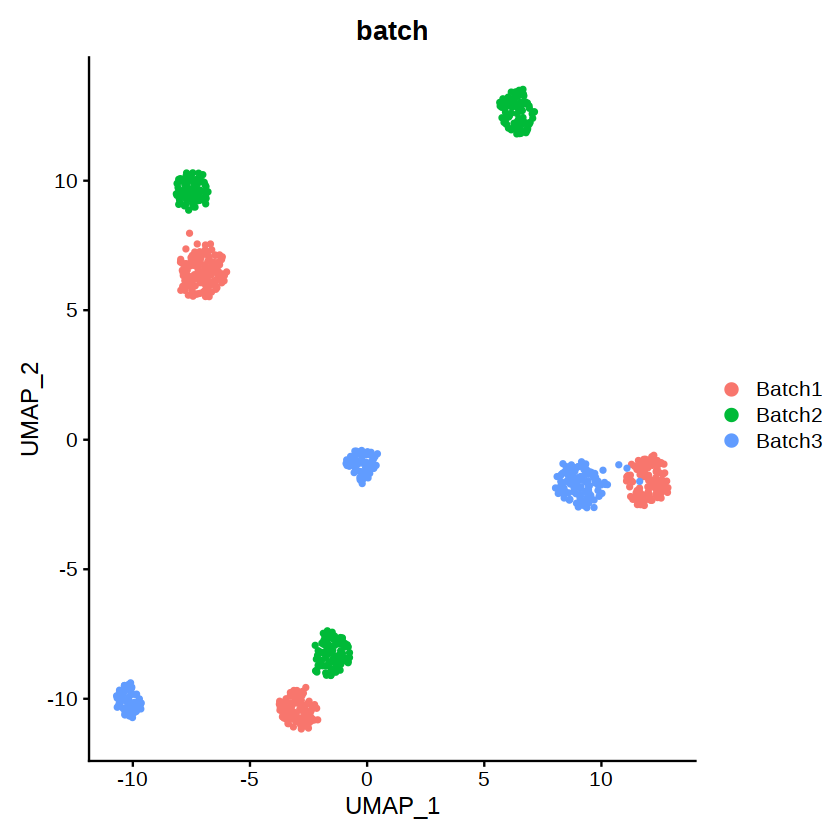

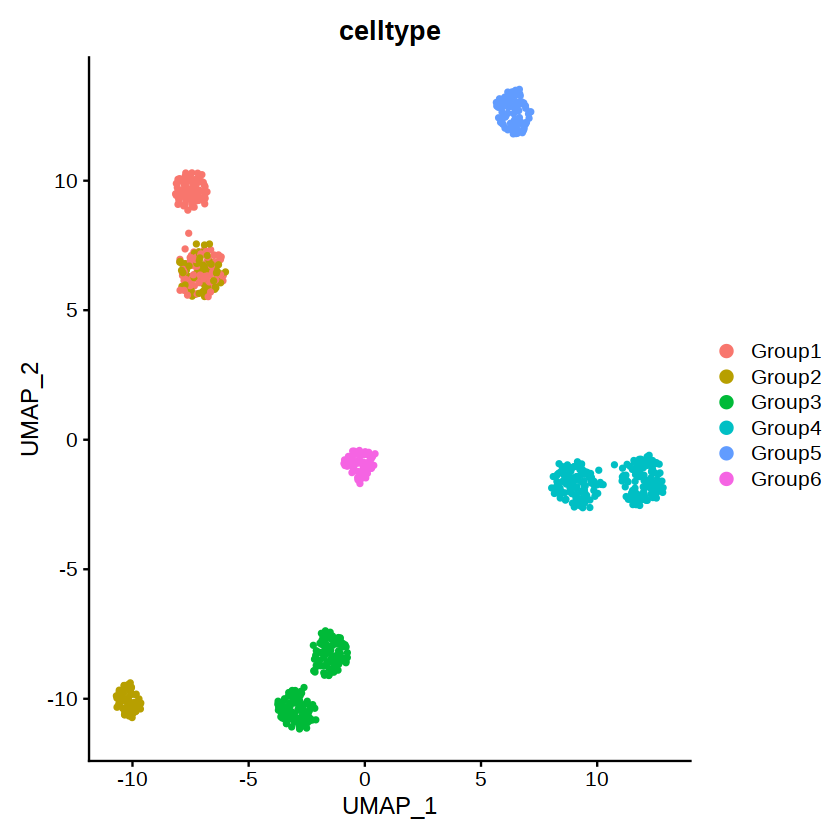

模拟空间位置 types1

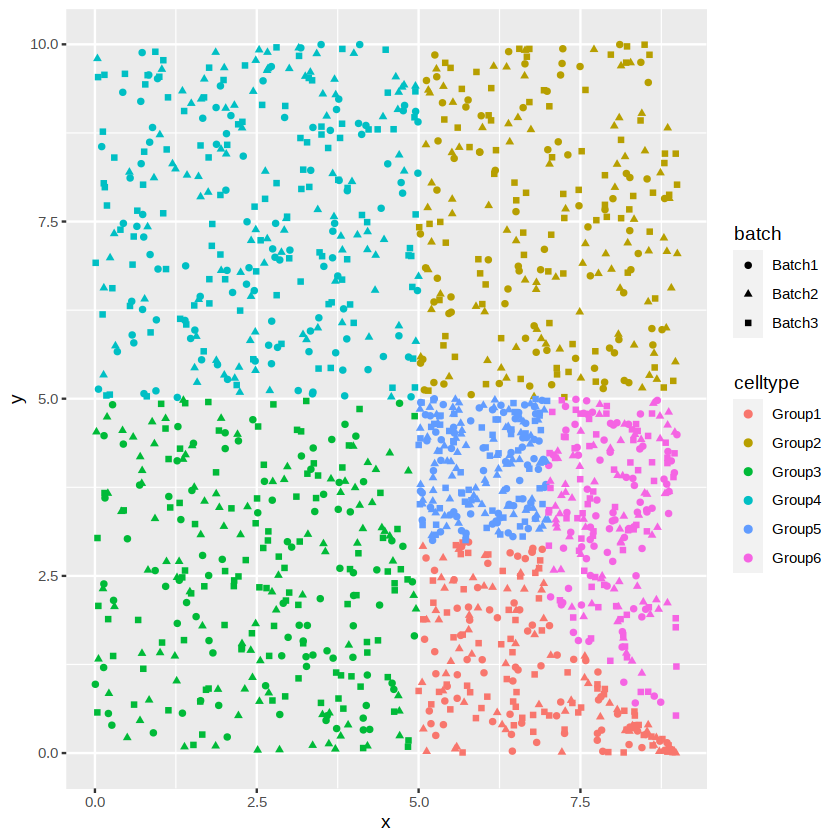

In [18]:
############################################
cells=colnames(mat)
ub=unique(meta$batch)
posi<-function(BID){
    X=range(0,10)
    Y=range(0,10)
    cell_1=cells[meta$batch==ub[BID]]
    celltype_1=meta$celltype[meta$batch==ub[BID]]
    celltype_1=factor(celltype_1,levels=c('Group1','Group2','Group3','Group4','Group5','Group6'))
    uc1=levels(celltype_1)
    ################################
    id=1
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    n=length(cell1)%/%3*2
    X1=runif(n, min=5, max=7)
    Y1=runif(n, min=0, max=3)
    X2=runif(length(cell1)-n, min=7, max=9)
    Y2=runif(length(cell1)-n,min=0,max=(9-X2))
    data1=data.frame(x=c(X1,X2),y=c(Y1,Y2),celltype=uc1[id],batch=ub[BID])
    rownames(data1)<-cell1

    id=2
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    X1=runif(length(cell1), min=5, max=9)
    Y1=runif(length(cell1), min=5, max=10)
    data2=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
    rownames(data2)<-cell1

    id=3
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    X1=runif(length(cell1), min=0, max=5)
    Y1=runif(length(cell1), min=0, max=5)
    data3=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
    rownames(data3)<-cell1

    id=4
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    X1=runif(length(cell1), min=0, max=5)
    Y1=runif(length(cell1), min=5, max=10)
    data4=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
    rownames(data4)<-cell1

    id=5
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    X1=runif(length(cell1), min=5, max=7)
    Y1=runif(length(cell1), min=3, max=5)
    data5=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
    rownames(data5)<-cell1

    id=6
    cell1=cell_1[celltype_1==uc1[id]]
    cell1=sample(cell1,length(cell1),replace=F)
    n=length(cell1)%/%3*2
    X1=runif(n, min=7, max=9)
    Y1=runif(n, min=3, max=5)
    X2=runif(length(cell1)-n, min=7, max=9)
    Y2=runif(length(cell1)-n,min=(9-X2),max=3)
    data6=data.frame(x=c(X1,X2),y=c(Y1,Y2),celltype=uc1[id],batch=ub[BID])
    rownames(data6)<-cell1
    data_1=rbind(data1,rbind(data2,rbind(data3,rbind(data4,rbind(data5,data6)))))
    return(data_1)
}
data_1=posi(1)
data_2=posi(2)
data_3=posi(3)
data=rbind(data_1,data_2,data_3)
ggplot(data,aes(x,y,color=celltype,shape=batch))+geom_point()
write.table(data,paste(dirs,"origin/spatial_posi",batch_sim,types,".txt",sep=""),row.names=T,col.names=T,quote=F,sep=',')

模拟空间位置 types5

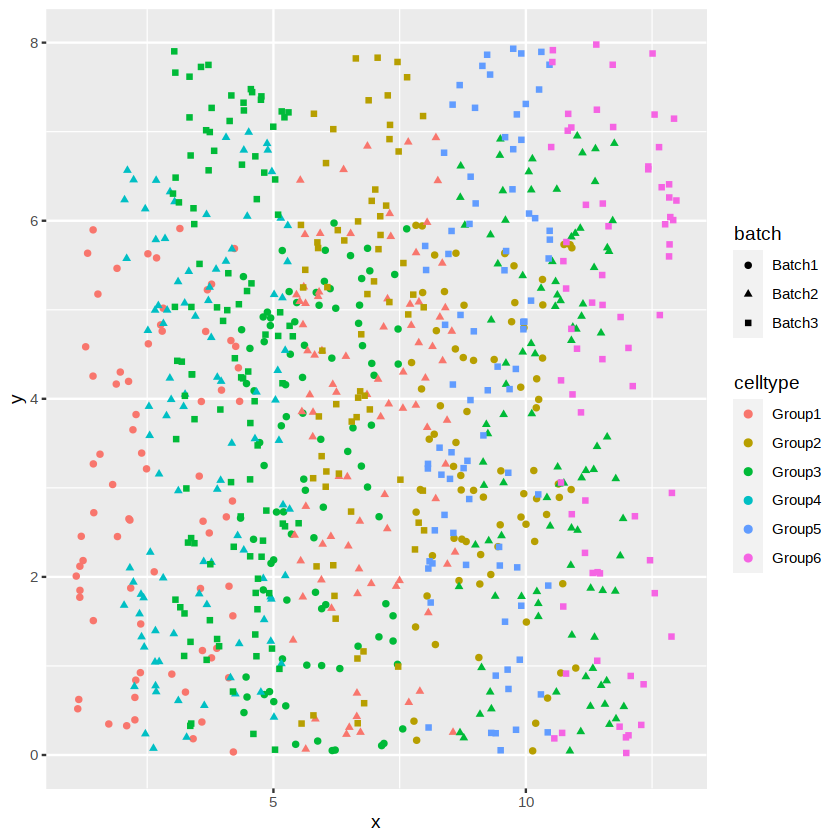

In [25]:
############################################
cells=colnames(mat)
ub=unique(meta$batch)
posi<-function(BID,cell_levels){
    
    cell_1=cells[meta$batch==ub[BID]]
    celltype_1=meta$celltype[meta$batch==ub[BID]]
    celltype_1=factor(celltype_1,levels=cell_levels)
    uc1=levels(celltype_1)
    X=seq(0,10,10/(length(uc1)))+BID
    Y=5+BID
    data1=data.frame(x=0,y=0,celltype=0,batch=0)
    for(id in 1:length(uc1)){
        cell1=cell_1[celltype_1==uc1[id]]
        cell1=sample(cell1,length(cell1),replace=F)
        X1=runif(length(cell1), min=X[id], max=X[id+1])
        Y1=runif(length(cell1), min=0, max=Y)
        a=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
        rownames(a)<-cell1
        data1=rbind(data1,a)
    }
    data1=data1[-1,]
    return(data1)
}
data_1=posi(1,c('Group1','Group3','Group2'))
data_2=posi(2,c('Group4','Group1','Group3'))
data_3=posi(3,c('Group3','Group2','Group5','Group6'))
data=rbind(data_1,data_2,data_3)
ggplot(data,aes(x,y,color=celltype,shape=batch))+geom_point()
write.table(data,paste(dirs,"origin/spatial_posi",batch_sim,types,".txt",sep=""),row.names=T,col.names=T,quote=F,sep=',')

模拟空间位置 types6

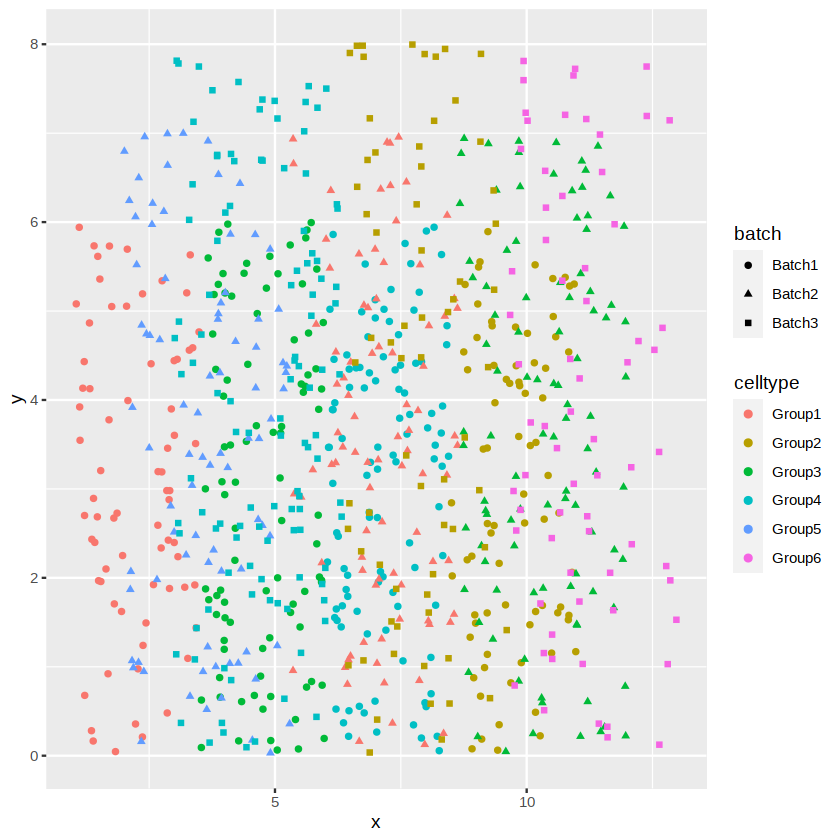

In [11]:
############################################
cells=colnames(mat)
ub=unique(meta$batch)
posi<-function(BID,cell_levels){
    
    cell_1=cells[meta$batch==ub[BID]]
    celltype_1=meta$celltype[meta$batch==ub[BID]]
    celltype_1=factor(celltype_1,levels=cell_levels)
    uc1=levels(celltype_1)
    X=seq(0,10,10/(length(uc1)))+BID
    Y=5+BID
    data1=data.frame(x=0,y=0,celltype=0,batch=0)
    for(id in 1:length(uc1)){
        cell1=cell_1[celltype_1==uc1[id]]
        cell1=sample(cell1,length(cell1),replace=F)
        X1=runif(length(cell1), min=X[id], max=X[id+1])
        Y1=runif(length(cell1), min=0, max=Y)
        a=data.frame(x=X1,y=Y1,celltype=uc1[id],batch=ub[BID])
        rownames(a)<-cell1
        data1=rbind(data1,a)
    }
    data1=data1[-1,]
    return(data1)
}
data_1=posi(1,c('Group1','Group3','Group4','Group2'))
data_2=posi(2,c('Group5','Group1','Group3'))
data_3=posi(3,c('Group4','Group2','Group6'))
data=rbind(data_1,data_2,data_3)
ggplot(data,aes(x,y,color=celltype,shape=batch))+geom_point()
write.table(data,paste(dirs,"origin/spatial_posi",batch_sim,types,".txt",sep=""),row.names=T,col.names=T,quote=F,sep=',')